In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from csc.utils import *
from csc.atoms import *
from csc.dictionary import *
from csc.workbench import *
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Atom parameters
bmin = 0.005
bmax = 0.06
b_step = 0.005
b_values = np.arange(bmin, bmax, b_step)

ymin = 0.010
ymax = 0.036
y_step = 0.002
y_values = np.arange(ymin, ymax, y_step)

s_values = [1]

dictionary = ZSDictionary.from_values(b_values, y_values, s_values)
print('The dictionary has {} different atoms'.format(len(dictionary)))

The dictionary has 143 different atoms


In [2]:
batchSize = 200
path_to_mmpdf_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mmpdf-{batchSize}.json'
path_to_mp_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mp-{batchSize}.json'

pomme = False

if pomme :
    input_signals_db = f'/home/gomes/synthetic-data/csc-signals-{batchSize}.json'
    input_mmpdf_db = f'/home/gomes/synthetic-data/csc-mmpdf-{batchSize}.json'
    input_mp_db = f'/home/gomes/synthetic-data/csc-mp-{batchSize}.json' 
    
else:
    input_signals_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-signals-{batchSize}.json'
    input_mmpdf_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mmpdf-{batchSize}.json'
    input_mp_db = f'C:\\Users\\gomes\\Documents\\ENS\\00_M1\\00_BORELLI\\01_WorkInProgress\\\synthetic-data\\csc-mp-{batchSize}.json'


In [3]:
workbench = CSCWorkbench(input_signals_db)
workbench.load_data()
workbench.set_dictionary(dictionary)

In [4]:
with open(input_signals_db, 'r') as f:
            output_data = json.load(f)
            signals_results = output_data['signals']

In [5]:
signal_dicts = [x for x in signals_results if x['sparsity'] == 4 and x['snr'] == 10]

#### Define the MMP-DF parameters

In [6]:
MAX_SPARSITY = 4
CONNECTIONS = 3
BRANCHES = 10
pos_err_threshold = 10      ## << POS_ERR_THRESHOLD >>
correlation_threshold = 0.75 ## << CORRELATION_THRESHOLD >>

 #### Define the DISSIMILARITY LIST 

In [7]:
DISSIMILARITY_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [8]:
verbose = False
results = []

# Utiliser tqdm pour ajouter une barre de progression externe
for DISSIMILARITY in tqdm(DISSIMILARITY_LIST, desc='Processing Dissimilarities'):
    list_tp = []
    # Utiliser tqdm pour ajouter une barre de progression interne
    for signal_dict in tqdm(signal_dicts, desc='Processing Signals', leave=False):
        true_atoms = signal_dict['atoms']
        true_sparsity = len(true_atoms)
        
        mmp_sparVar_results = dictionary.mmpdfSparVarFromDict(
            signal_dict=signal_dict, 
            connections_level=CONNECTIONS,
            dissimilarity=DISSIMILARITY,
            nb_branches=BRANCHES,
            max_sparsity=MAX_SPARSITY,
            verbose=False
        )

        mmp_results = mmp_sparVar_results['results']
        mmp_dict_approx = mmp_results[true_sparsity - 1]
        approx_atoms = mmp_dict_approx['atoms']
        approx_path = mmp_dict_approx['path']

        tp = workbench.computeTruePositives(true_atoms, approx_atoms, pos_err_threshold, correlation_threshold, verbose=verbose)
        list_tp.append(tp)
    
    # Calculer la moyenne des true positives pour la dissimilarité actuelle
    mean_tp = np.mean(list_tp)
    # Ajouter les résultats au DataFrame
    for tp in list_tp:
        results.append({'DISSIMILARITY': DISSIMILARITY, 'TP': tp})

Processing Dissimilarities: 100%|██████████| 9/9 [2:42:42<00:00, 1084.73s/it] 


### Boxplot 

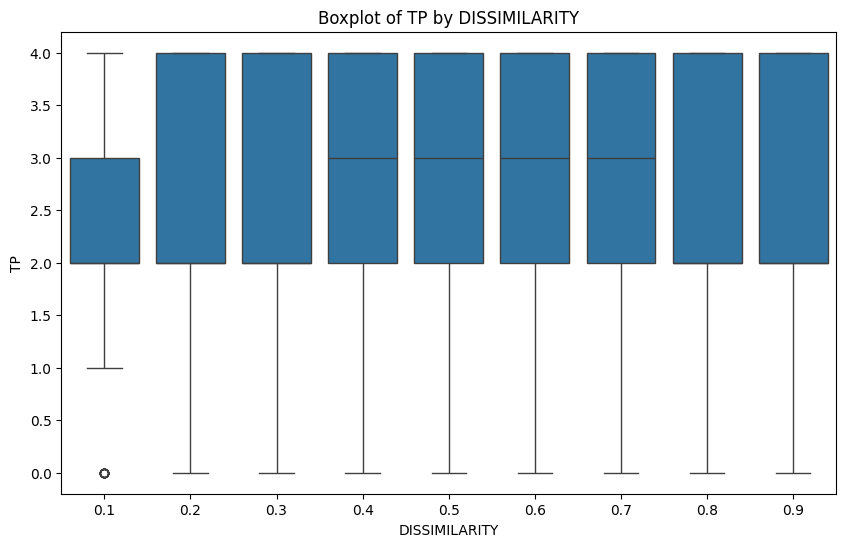

In [9]:
df_results = pd.DataFrame(results)
# Configurer Seaborn pour afficher le boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='DISSIMILARITY', y='TP', data=df_results)
plt.title('Boxplot of TP by DISSIMILARITY')
plt.xlabel('DISSIMILARITY')
plt.ylabel('TP')
plt.show()

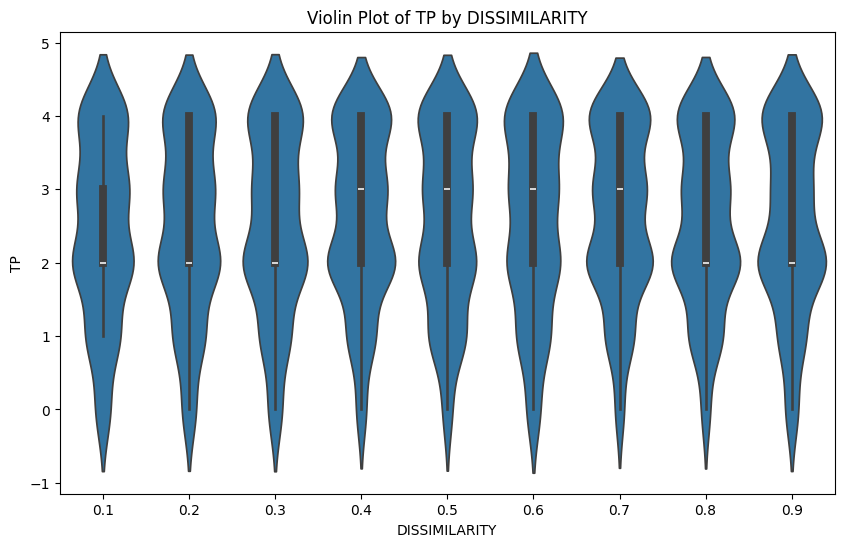

In [10]:
# Créer un DataFrame Pandas à partir des résultats
df_results = pd.DataFrame(results)

# Configurer Seaborn pour afficher le violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='DISSIMILARITY', y='TP', data=df_results)
plt.title('Violin Plot of TP by DISSIMILARITY')
plt.xlabel('DISSIMILARITY')
plt.ylabel('TP')
plt.show()